In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping
import math
from typing import Optional 


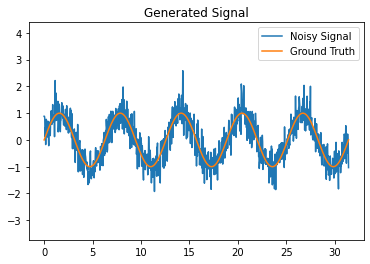

In [16]:
#Generating example noisy signal
np.random.seed(123456789)
tspan =  np.linspace(0, 10*np.pi, 1000) 
teval = 0
Vin = lambda t: np.sin(t)
mynoise = 0.4*np.random.randn(*Vin(tspan).shape)
Vinarray = Vin(tspan) + mynoise

plt.plot(tspan, Vinarray, label='Noisy Signal')
plt.plot(tspan, Vin(tspan), label='Ground Truth')
plt.legend(loc='upper right')
plt.margins(0.05, 0.4)
plt.title("Generated Signal")
plt.show()

In [17]:
#root class for all filters
class Filters:
    def __init__(self, tspan, signal):
        self.tspan = tspan
        self.signal = signal
    
    #used to find nearest time index for RK45 integrator
    def find_nearest(self, array, value):
        idx = np.searchsorted(array, value, side="left")
        if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
            return idx-1
        else:
            return idx
        
#directly transferred from circuits        
class TimesteppedFilters(Filters):
    
    #returns function derivative at discrete points for timestepping(tspan)
    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)
        
    def lowpassdisc(self, t, y, signal, tau):
        dydt = (1/tau)*(signal[self.find_nearest(self.tspan, t)]-y)
        return dydt
    
    def highpassdisc(self, t, y, signal, tau):
        dydt = (signal[self.find_nearest(self.tspan, t)]+
                signal[self.find_nearest(self.tspan, t)-1])/(self.tspan[self.find_nearest(self.tspan, t)]
                -self.tspan[self.find_nearest(self.tspan, t)-1])-y/tau
        return dydt       

    #integrators for filter equations
    def solvelow(self, tau, scale):
        sol_low = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])
        return sol_low.y[0, :]
    
    def solvehigh(self, tau, scale):
        sol_high = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[self.signal, tau])
        return sol_high.y[0]
    
    def solvebandpass(self, tau1, tau2, scale):
        lowpass = self.solvelow(tau1).y[0]
        bandpass = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[lowpass, tau2])
        return bandpass.y[0]
    
    #crude minimal global error
    def optsolve(self, truth, ftype):
        if ftype=='lowpass':
            params = np.empty(2)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.075
            minscale = 0
            minerr = np.linalg.norm((sol.y[0])*(np.max(truth)/np.max(sol.y[0])))
            for n in range(2, 20):
                gtau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = scale*sol.y[0]
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-scale)/scale > len(scale)-2:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err) < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = minscale
            params[1] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = minscale*bestsolve.y[0]
            return bestsolve, params
        
        elif ftype=='highpass':
            params = np.empty(2)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.075
            minscale = 0
            minerr = np.linalg.norm((sol.y[0])*(np.max(truth)/np.max(sol.y[0])))
            for n in range(2, 20):
                gtau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = scale*sol.y[0]
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-scale)/scale > len(scale)-2:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err) < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = minscale
            params[1] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = minscale*bestsolve.y[0]
            return bestsolve, params            
        
        elif ftype=='bandpass':
            low, lowparam = self.optsolve(Vin(tspan), ftype='lowpass')
            params = np.empty(4)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[low.y[0], tau])  
            mintau = 0.075
            minscale = 0
            minerr = np.linalg.norm((sol.y[0])*(np.max(truth)/np.max(sol.y[0])))
            for n in range(2, 20):
                gtau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[low.y[0], tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = scale*sol.y[0]
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-scale)/scale > len(scale)-2:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err) < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = lowparam[0]
            params[1] = lowparam[1]
            params[2] = minscale
            params[3] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[low.y[0], mintau])  
            bestsolve.y[0] = minscale*bestsolve.y[0]
            return bestsolve, params

    #graphing filtration, option to graph alongside truth signal
    def graph(self, opt, ftype, truth=None):
        sol = opt[0]
        params = opt[1]
        plt.plot(sol.t, sol.y[0,:], label='Filtered')
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label='Ground truth')
        if ftype=='Low Pass' or ftype=='High Pass':
            plt.title("%s, RK45 Integrator, Params [Scale: %f, Tau: %f]" %(ftype, params[0], params[1]))
        elif ftype=='Band Pass':
            plt.title("%s, RK45 Integrator, Params [Scales: %f, %f, Taus: %f, %f]" %(ftype, params[0], params[2], params[1], params[3]))    
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.show()
        
#digital Butterworth Filters        
class ButterworthFilters(Filters):

    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)  
    
    #Butterworth filter solvers for input parameters
    def lbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='lowpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def hbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='highpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bpassbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bstopbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandstop')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)] 
   
    #optimizes Butterworth filter parameters, sampling over whole domain for global minima
    def optparams(self, orders, truth, ftype):
        if ftype=='lowpass':             
            popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[1, 0.5], bounds=(0, [np.inf, 0.99]))
            minerr = np.linalg.norm(truth-self.lbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[order, 0.5], bounds=(0, [np.inf, 0.99]))
                err = np.linalg.norm(truth-self.lbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.lbutt, self.tspan, truth, p0=[minorder, 0.5], bounds=(0, [np.inf, 0.99]))
            y = self.lbutt(self.tspan, *minpopt)
            return y, minpopt
            
        elif ftype=='highpass':  
            popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[1, 0.01], bounds=(0, [np.inf, 0.99]))
            minerr = np.linalg.norm(truth-self.hbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[order, 0.01], bounds=(0, [np.inf, 0.99]))
                err = np.linalg.norm(truth-self.hbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.hbutt, self.tspan, truth, p0=[minorder, 0.01], bounds=(0, [np.inf, 0.99]))
            y = self.hbutt(self.tspan, *minpopt)
            return y, minpopt                
           
        elif ftype=='bandpass':  
            popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[1, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = np.linalg.norm(truth-self.bpassbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[order, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
                err = np.linalg.norm(truth-self.bpassbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bpassbutt(self.tspan, *minpopt)
            return y, minpopt 
        
        elif ftype=='bandstop':  
            popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[1, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = np.linalg.norm(truth-self.bstopbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[order, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
                err = np.linalg.norm(truth-self.bstopbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bstopbutt(self.tspan, *minpopt)
            return y, minpopt 
    
    #graphing filtration, option to graph alongside truth signal
    def graph(self, y, popt, ftype, truth=None):
        plt.plot(self.tspan, y, label="Filtered")
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label="Ground truth")
        if ftype=="Low Pass" or ftype=="High Pass":
            plt.title("Bandworth type: %s, Params [Ord: %d, Freq: %f]" %(ftype, int(popt[0]), popt[1]))
        elif ftype=="Band Pass" or ftype=="Band Stop":
            plt.title("Bandworth type: %s, Params [Ord: %d, Freqs: %f, %f]" %(ftype, int(popt[0]), popt[1], popt[2]))
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.show()

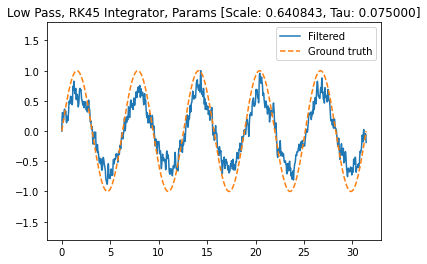

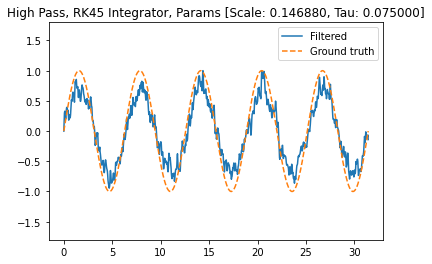

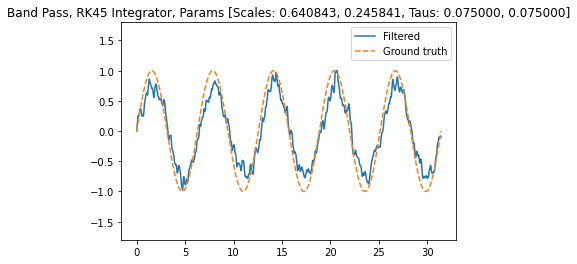

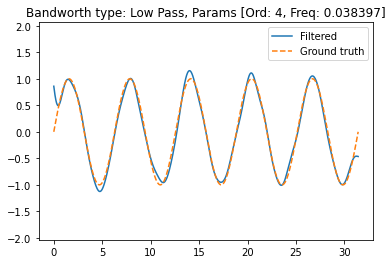

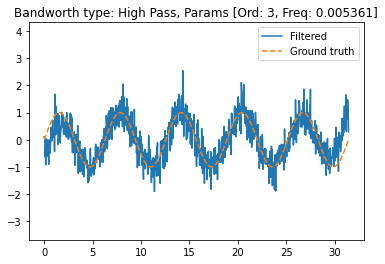

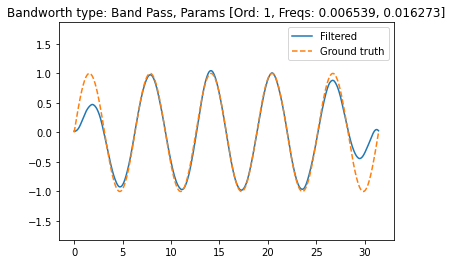

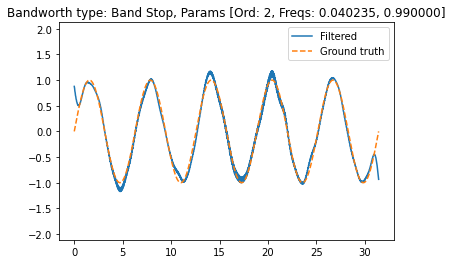

In [18]:
#Filter simulations and graphing
#Only code user needs to access all filters

filtered = TimesteppedFilters(tspan, Vinarray)
lowfilter = filtered.optsolve(Vin(tspan), ftype='lowpass')
filtered.graph(lowfilter, "Low Pass", Vin(tspan))

highfilter = filtered.optsolve(Vin(tspan), ftype='highpass')
filtered.graph(highfilter, "High Pass", Vin(tspan))

bandpassfilter = filtered.optsolve(Vin(tspan), ftype='bandpass')
filtered.graph(bandpassfilter, "Band Pass", Vin(tspan))

butterworth = ButterworthFilters(tspan, Vinarray)
butterlow = butterworth.optparams(10, Vin(tspan), ftype='lowpass')
butterworth.graph(butterlow[0], butterlow[1], "Low Pass", truth=Vin(tspan))

butterhigh = butterworth.optparams(10, Vin(tspan), ftype='highpass')
butterworth.graph(butterhigh[0], butterhigh[1], "High Pass", truth=Vin(tspan))

butterbpass = butterworth.optparams(10, Vin(tspan), ftype='bandpass')
butterworth.graph(butterbpass[0], butterbpass[1], "Band Pass", truth=Vin(tspan))

butterbstop = butterworth.optparams(10, Vin(tspan), ftype='bandstop')
butterworth.graph(butterbstop[0], butterbstop[1],"Band Stop", truth=Vin(tspan))
#b, a = scipy.signal.cheby1(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan,  y)

#b, a = scipy.signal.cheby2(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan, y)